 ### please re-start kernel if these packages are installed for the first time

In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

### This template is for
- objFuncs: v1.0.3  
- pyBO: v1.0.1

In [1]:
import objFuncs
from objFuncs import maximize_FC, construct_machineIO
from objFuncs.preset import get_preset, get_tolerance
from pyBO import pyBO

objFuncs version: 1.0.3. updated on 2024-03-11
pyBO version: 1.0.1. updated on 2024-03-15


In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
from phantasy import caget,fetch_data
import pandas as pd

# user inputs
### check and adjust decision (control knobs) and objectives later

In [4]:
is_close_to_opt = True      # True for local optimization. 
sourceFC = 30               # uA
timespan_for_average = 1    # sec  
additional_wait_after_powersupply_ramp  = 0.25 # sec

In [6]:
budget = 30
if not is_close_to_opt:
    budget += int(0.3*budget)
    
print(f"budget: {budget}")

budget: 48


# check machineIO, source and beam  

In [7]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = timespan_for_average
objFuncs._global_machineIO._ensure_set_timewait_after_ramp = additional_wait_after_powersupply_ramp

   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 1
   _return_obj_var : False
   _check_chopper_blocking : True
   _n_popup_ramping_not_OK : 0
   _verbose : False
   history : {}
   _test : False


In [8]:
SCS = caget("ACS_DIAG:DEST:ACTIVE_ION_SOURCE")
ion = caget("FE_ISRC"+str(SCS)+":BEAM:ELMT_BOOK")
Q = caget("FE_ISRC"+str(SCS)+":BEAM:Q_BOOK")
A = caget("FE_ISRC"+str(SCS)+":BEAM:A_BOOK")
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS1 124Xe26 A/Q= 4.769230769230769


In [9]:
now0 = datetime.datetime.now()
fname = now0.strftime('%Y%m%d_%H%M')+'['+ion+'][pyBO][U-LEBT]FC814'
fname

'20240317_1012[124Xe26][pyBO][U-LEBT]FC814'

# preprare decision ( control knob)

In [10]:
# preset = get_preset('[U-LEBT]FC814')
# preset

In [11]:
decision_CSETs = [
                  'FE_LEBT:PSC2_D0773:I_CSET',
                  'FE_LEBT:PSC1_D0773:I_CSET',
                  'FE_LEBT:PSC2_D0790:I_CSET',
                  'FE_LEBT:PSC1_D0790:I_CSET',
#                   'FE_LEBT:PSOL_D0787:I_CSET',
                  ]
ave, _ = fetch_data(decision_CSETs,0.01)

decision_tols = []
decision_min = []
decision_max = []
for v, PV in zip(ave,decision_CSETs):
    if 'PSC' in PV:
        decision_min.append(v-AQ)
        decision_max.append(v+AQ)
        decision_tols.append(0.2)
    elif 'PSOL' in PV:
        decision_min.append(0.9*v)
        decision_max.append(1.1*v)
        decision_tols.append(1.0)
    else:
        raise ValueError(f'decision bounds for {PV} cannot be determined')

# decision_tol = get_tolerance(decision_CSETs)
# if decision_tol is None:
#     decision_tol = [0.2]*len(decision_CSETs)

pd.DataFrame(np.array([ave,decision_min,decision_max,decision_tols]).T,
             index=decision_CSETs, 
             columns=['current value','decision min','decision max','tol'])

,current value,min,max,tol
FE_LEBT:PSC2_D0773:I_CSET,-0.829769,-5.599000,3.939462,0.2
FE_LEBT:PSC1_D0773:I_CSET,0.510487,-4.258744,5.279718,0.2
FE_LEBT:PSC2_D0790:I_CSET,-0.746240,-5.515471,4.022990,0.2
FE_LEBT:PSC1_D0790:I_CSET,1.041223,-3.728007,5.810454,0.2


# preprare objective function

In [12]:
obj = maximize_FC.maximize_FC814(
    decision_CSETs=decision_CSETs,
    decision_min = decision_min,
    decision_max = decision_max,
    decision_tols = decision_tols,
    objective_goal   = {'FE_LEBT:FC_D0814:PKAVG_RD': {'more than': sourceFC}},
    objective_weight = {'FE_LEBT:FC_D0814:PKAVG_RD': 1},
    objective_norm   = {'FE_LEBT:FC_D0814:PKAVG_RD': 0.2*sourceFC},
)

======== class info ========
init_time: 2024-03-17 08:47:15.318962
class_hierarchy: [
    maximize_FC814, objFuncGoals, objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f66a501b6d0>
decision_CSETs: [
    FE_LEBT:PSC2_D0773:I_CSET, FE_LEBT:PSC1_D0773:I_CSET, FE_LEBT:PSC2_D0790:I_CSET
    FE_LEBT:PSC1_D0790:I_CSET, FE_LEBT:PSOL_D0787:I_CSET]
decision_min: [-5.77912376 -4.44542803 -5.18852931 -3.45139013 72.9936    ]
decision_max: [ 3.75933778  5.09303351  4.34993223  6.08707141 89.2144    ]
decision_bounds : array of shape (5, 2) and type float64
decision_RDs: [
    FE_LEBT:PSC2_D0773:I_RD, FE_LEBT:PSC1_D0773:I_RD, FE_LEBT:PSC2_D0790:I_RD
    FE_LEBT:PSC1_D0790:I_RD, FE_LEBT:PSOL_D0787:I_RD]
decision_tols: [0.2 0.2 0.2 0.2 4. ]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: FC814
logging_fname: None
x0: [-1.00989299  0.32380274 -0.41929854  1.31784064 81.104     ]
plot_time_val: <class 'objFuncs.util.plot_time_

# run Optim

In [13]:
ctrBO = pyBO.bo_controller(obj,
                           local_optimization = is_close_to_opt,
                           budget=budget)

init will random sample with the followings info:
  n_init: 5


,min,max
FE_LEBT:PSC2_D0773:I_CSET,-1.725278,-0.294508
FE_LEBT:PSC1_D0773:I_CSET,-0.391582,1.039187
FE_LEBT:PSC2_D0790:I_CSET,-1.134683,0.296086
FE_LEBT:PSC1_D0790:I_CSET,0.602456,2.033225
FE_LEBT:PSOL_D0787:I_CSET,79.887440,82.320560


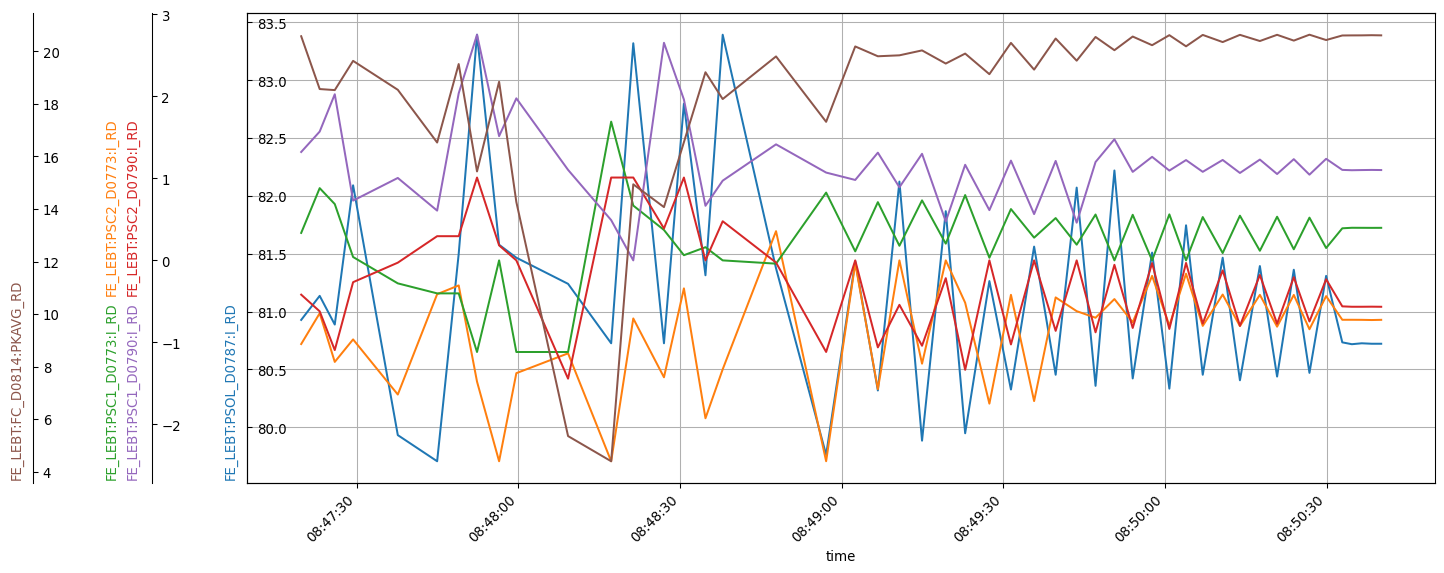

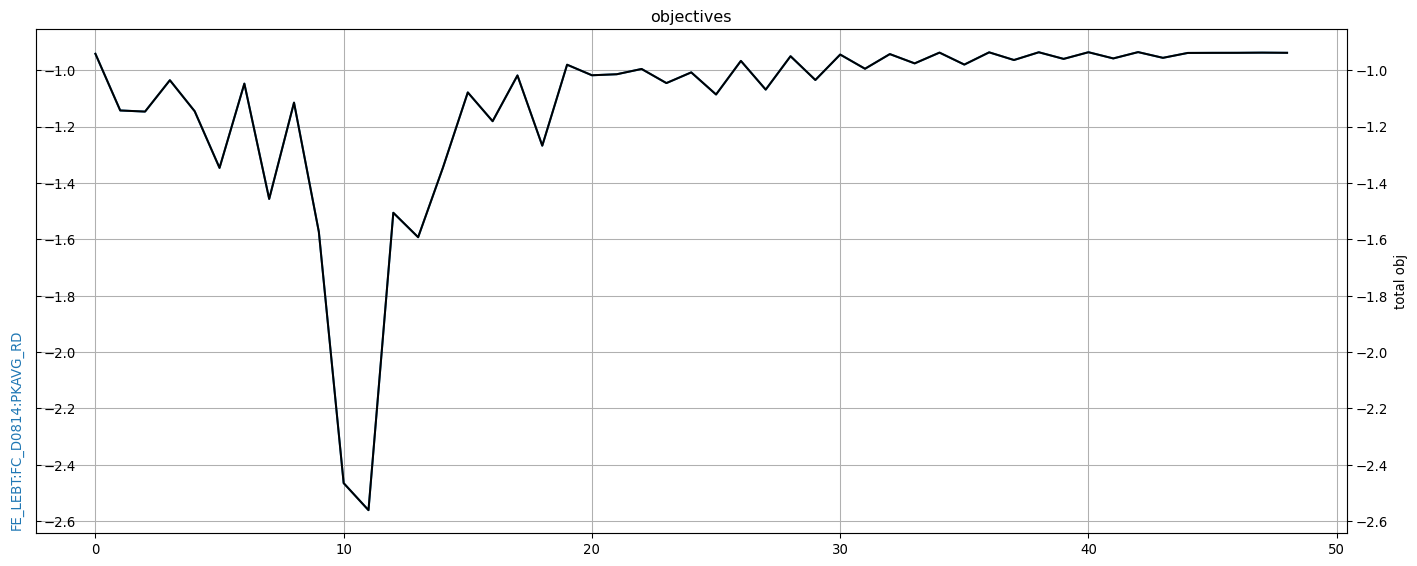

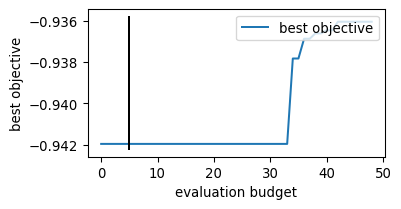

In [14]:
# optimize
ctrBO.init()      # random search
ctrBO.optimize()  # adaptive opt: global -> local -> finetune

### additional optimization

In [ ]:
# ctrBO.optimize_global(niter=4)     # uncomment for additional global search
# ctrBO.optimize_local(niter=4)      # uncomment for additional local search near best solution
# ctrBO.fine_tune(niter=2)           # uncomment for additional finetune near best solution
for f in ctrBO.plot_callbacks:
    f.close()

### plot accumulated best objectives

In [ ]:
fig,ax = plt.subplots(figsize=(4,2),dpi=96)
ctrBO.bo.plot_obj_history(ax=ax, plot_best_only=True)

### set to best solution 

In [15]:
x_best,y_best_old = ctrBO.bo.best_sofar()
y_best_new = obj(x_best)
print(x_best,y_best_old[0],y_best_new)   # check if best solution objective value is consistent

[-0.82976906  0.51048709 -0.74624036  1.04122345 80.63613028] -0.9360488401585487 -0.9347135957761025


In [16]:
obj.save(fname=os.path.join('/files/shared/ap/jupyter-notebook/data/log/',fname))

# Visualize Surrogate model

starting projection plot...
[████████████████████████████████████████] 100%/100%

starting projection plot...
[████████████████████████████████████████] 100%/100%



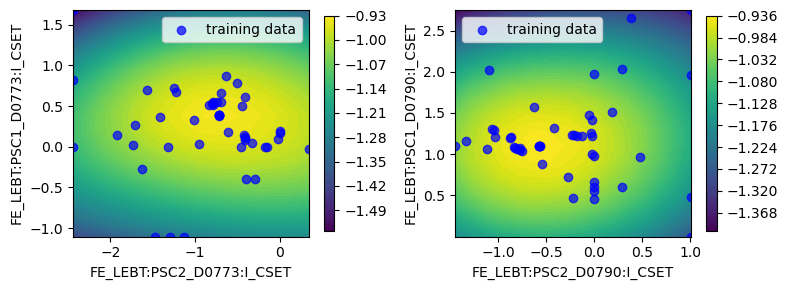

In [17]:
# plot surrogate mean model of the last epoch. Can take long time for decision dim >= 4
bo = ctrBO.bo
from math import ceil
nplot = int(0.5*len(obj.decision_CSETs))
nrow = ceil(0.5*nplot)
fig,ax = plt.subplots(nrow,2,figsize=(8,3*nrow))
for i in range(nrow):
    for j in range(2):
        n = 2*i+j
        if nrow>1:
            ax_ = ax[i,j]
        else:
            ax_ = ax[j]
        if n >= nplot:
            ax_.set_visible(False)
            break
        bo.plot_model_2D_projection(project_maximum=True,
                                    dim_xaxis = 2*n,
                                    dim_yaxis = 2*n+1,
                                    grid_ponits_each_dim = 16,
                                    fig=fig,ax=ax_);
        ax_.set_xlabel(obj.decision_CSETs[2*n  ])
        ax_.set_ylabel(obj.decision_CSETs[2*n+1])
        ax_.legend()
fig.tight_layout()